In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
is_cuda_available = torch.cuda.is_available()

In [4]:
print(is_cuda_available)

True


### Load STL-10

In [5]:
classes = ()

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train data
batch_size = 32
trainset = torchvision.datasets.STL10(root='./data',
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [8]:
total = len(trainset)
ind = list(range(total))
n_train = int(np.floor((0.9) * total))
train_ind, validation_ind = ind[:n_train], ind[n_train:]
train_subsampler = torch.utils.data.sampler.SubsetRandomSampler(train_ind)
validation_subsampler = torch.utils.data.sampler.SubsetRandomSampler(validation_ind)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=train_subsampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                sampler=validation_subsampler, num_workers=0)

print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(validation_loader)))

Number of training batches: 141
Number of validation batches: 16


# Show images

In [9]:
def show_images(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

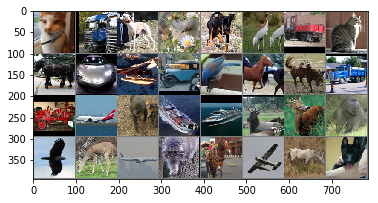

In [10]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
show_images(torchvision.utils.make_grid(images))
# print labels

# Shuffle Images

In [11]:
def permute_pieces(images):
    """
    Shuffle pieces pieces.
    """
    size = images.shape[0]
    perm = torch.randperm(size)
    
    perm_mat = torch.zeros(size, size)
    perm_mat[torch.arange(size).long(), perm] = 1
    return images[perm].contiguous(), perm_mat

# Cut Images

In [12]:
def cut_torch_imgs(imgs, shape = (4,4)):
    # imgs is a batch of images -- expected n*c*h*w
    # shape is the shape of each piece
    # returns n*pieces*c*h*w
    assert len(imgs.shape) == 4,"Provide batches of inputs"
    assert not imgs.shape[2] % shape[0], "undivisible height for piece size"
    assert not imgs.shape[3] % shape[1], "undivisible width for piece size"
    
    a = imgs.transpose(1, 2).transpose(2,3).contiguous()
    c = a[0].shape[-1]
    x,y = a[0].shape[0]//shape[0], a[0].shape[1]//shape[1]
    b = a.view(-1,x,shape[0],y,shape[1],c)
    b = b.transpose(2,3).contiguous()
    b = b.view(-1,x*y,shape[0],shape[1],c)
    #transpose to torch accepted standard
    b = b.transpose(3,4).transpose(2,3).contiguous()
    res = []
    for i in range(b.shape[0]):
        temp, perm = permute_pieces(b[i])
        b[i] = temp
        res.append(perm)
    res = torch.stack(res)
    return b, res.reshape(-1, res.shape[1]*res.shape[2])

In [ ]:
s, r = cut_torch_imgs(images[0:4], (32,32))

In [ ]:
s.shape, r.shape

In [ ]:
show_images(s[0][4])

In [ ]:
images[0].shape

In [ ]:
show_images(images[0])

# Models

In [15]:
vgg16 = models.vgg16(pretrained=True)

In [16]:
# model = nn.Sequential(*list(vgg16.features.children())[:24])
vgg_part = nn.Sequential(vgg16.features)

In [17]:
temp = vgg_part(s[0])

NameError: name 's' is not defined

In [ ]:
temp.view(s[0].shape[0],-1).shape, temp.shape

In [ ]:
s[0].shape

# LSTM Test 1

In [ ]:
torch.randn(1, 1, 3)

In [ ]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    print(hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension

In [ ]:
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

In [ ]:
# Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history

# Custom Metrics

In [17]:
def preflow_accuracy(p_pred, p_true, pieces = 9, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    p_pred = preflow_bipartite(p_pred, pieces)
#     print(p_pred.shape, p_true.shape)
#     print(p_pred)
    p_true = p_true.clone().cpu()
    n1 = torch.sum((torch.sum(p_pred == p_true, 1) == 4).float()) # Fake Acc
    n2 = torch.sum((torch.sum(p_pred == p_true, 1) == 9).float()) # Hard Acc
    n3 = torch.sum((torch.sum(p_pred == p_true, 1)/pieces).float()) # Soft Acc
    if average:
        return (n1 / p_pred.shape[0], n2 / p_pred.shape[0], n3 / p_pred.shape[0])
    else:
        return (n1, n2, n3)

In [18]:
from scipy.sparse import csr_matrix
import networkx as nx

def preflow_bipartite(x, pieces = 9):
    """
    Converts vectorized assignment matrices back to permutation vectors.
    Note: this function is compatible with GPU tensors.
    """    
    x = x.clone()
    x = x.view(-1, x.shape[1]//pieces, pieces).detach().cpu().numpy()
    res = []
    for val in x:
        G = nx.bipartite.from_biadjacency_matrix(csr_matrix(val))
        matches = nx.algorithms.matching.max_weight_matching(G)
        pieces = val.shape[0]
        res_mat = np.zeros((pieces, pieces))
        for i, j in matches:
            if i >= pieces:
                i, j = j, i
            res_mat[i % pieces, j % pieces] = 1
        res.append(res_mat.reshape(pieces*pieces))

    return torch.FloatTensor(res)

# Sai 

In [19]:
for param in vgg_part.parameters():
    param.requires_grad = False
vgg_part = torch.nn.DataParallel(vgg_part)
vgg_part = vgg_part.cuda() if is_cuda_available else vgg_part

In [20]:
tem = [[1,1],[2,2],[3,3],[4,4]]
tem = np.array(tem)
print(tem, tem.shape)

res = [[[1,2],[3,4]], [[1,2],[3,4]]]
np.array(res)

[[1 1]
 [2 2]
 [3 3]
 [4 4]] (4, 2)


array([[[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]]])

In [21]:
class JigsawNet(nn.Module):
    """
    A neural network that solves 2x2 jigsaw puzzles.
    """
    def __init__(self, sinkhorn_iter=0):
        global vgg_part
        super(JigsawNet, self).__init__()
        self.vgg = vgg_part
        self.fc1 = nn.Linear(9*512, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        # 4 x 4 assigment matrix
        self.fc2 = nn.Linear(256, 81)
    
    def forward(self, x):
        # Split the input into four pieces and pass them into the
        # same convolutional neural network.
        vgg_out = []
        for i in range(x.shape[1]):
            vgg_out.append(self.vgg(x[:,i]).squeeze())
        # Cat
        x = torch.cat(vgg_out, dim=1)
        # Dense layer
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

In [22]:
net = JigsawNet()
is_cuda_available = torch.cuda.is_available();
if is_cuda_available:
    net = net.cuda()

In [23]:
output = net(cut_torch_imgs(images[0:4], (32,32))[0])

In [24]:
output.shape

torch.Size([4, 81])

In [25]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

In [26]:
save_file_name = "PleaseWorkModel.pkl"

In [ ]:
loss_history = []
val_loss_history = []
acc_history = []
val_acc_history = []
nb_epochs = 20
for epoch in range(nb_epochs):
    running_loss = 0.0
    n_correct_pred = 0
    n_samples = 0
    epoch_outputs = []
    epoch_labels = []
    for i, data in enumerate(train_loader, 0):
        # get the inputs
#         print(data)
        inputs, labels = cut_torch_imgs(data[0], (32,32))
        n_samples += inputs.size()[0]
        if is_cuda_available:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size()[0]
        epoch_outputs.append(outputs)
        epoch_labels.append(labels)
        
        loss_history.append(running_loss / n_samples)
#         acc_history.append(n_correct_pred / n_samples)
        if i % 1 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0
    n_correct_pred = preflow_accuracy(torch.cat(epoch_outputs, dim=0), torch.cat(epoch_labels, dim=0))
    print("Accuracy: {}".format(n_correct_pred))

print('Finished Training')
history = {
        'loss': loss_history,
        'acc': acc_history,
    }
# Save the model when requested.
if save_file_name is not None:
    torch.save({
        'history': history,
        'model': net.state_dict(),
        'optimizer': optimizer.state_dict()
    }, save_file_name)

[1,     1] loss: 22.424
[1,     2] loss: 21.796
[1,     3] loss: 21.249
[1,     4] loss: 20.561
[1,     5] loss: 19.998
[1,     6] loss: 19.369
[1,     7] loss: 18.899
[1,     8] loss: 18.430
[1,     9] loss: 17.879
[1,    10] loss: 17.426
[1,    11] loss: 16.961
[1,    12] loss: 16.569
[1,    13] loss: 16.104
[1,    14] loss: 15.841
[1,    15] loss: 15.295
[1,    16] loss: 14.993
[1,    17] loss: 14.728
[1,    18] loss: 14.405
[1,    19] loss: 14.116
[1,    20] loss: 13.897
[1,    21] loss: 13.648
[1,    22] loss: 13.385
[1,    23] loss: 13.020
[1,    24] loss: 12.877
[1,    25] loss: 12.672
[1,    26] loss: 12.575
[1,    27] loss: 12.431
[1,    28] loss: 12.251
[1,    29] loss: 12.120
[1,    30] loss: 12.049
[1,    31] loss: 11.958
[1,    32] loss: 11.793
[1,    33] loss: 11.720
[1,    34] loss: 11.675
[1,    35] loss: 11.535
[1,    36] loss: 11.474
[1,    37] loss: 11.431
[1,    38] loss: 11.506
[1,    39] loss: 11.378
[1,    40] loss: 11.368
[1,    41] loss: 11.164
[1,    42] loss:

[3,    57] loss: 10.506
[3,    58] loss: 10.251
[3,    59] loss: 10.200
[3,    60] loss: 10.347
[3,    61] loss: 10.420
[3,    62] loss: 10.110
[3,    63] loss: 10.479
[3,    64] loss: 10.406
[3,    65] loss: 10.254
[3,    66] loss: 10.304
[3,    67] loss: 10.047
[3,    68] loss: 10.201
[3,    69] loss: 10.416
[3,    70] loss: 10.160
[3,    71] loss: 10.394
[3,    72] loss: 10.415
[3,    73] loss: 10.320
[3,    74] loss: 10.400
[3,    75] loss: 10.114
[3,    76] loss: 10.098
[3,    77] loss: 10.280
[3,    78] loss: 10.148
[3,    79] loss: 10.406
[3,    80] loss: 10.270
[3,    81] loss: 10.420
[3,    82] loss: 10.272
[3,    83] loss: 10.016
[3,    84] loss: 10.257
[3,    85] loss: 10.415
[3,    86] loss: 10.145
[3,    87] loss: 10.431
[3,    88] loss: 10.065
[3,    89] loss: 10.279
[3,    90] loss: 10.464
[3,    91] loss: 10.360
[3,    92] loss: 10.101
[3,    93] loss: 10.124
[3,    94] loss: 10.178
[3,    95] loss: 10.346
[3,    96] loss: 10.082
[3,    97] loss: 10.473
[3,    98] loss:

[5,   118] loss: 10.004
[5,   119] loss: 9.691
[5,   120] loss: 10.111
[5,   121] loss: 9.772
[5,   122] loss: 9.850
[5,   123] loss: 9.565
[5,   124] loss: 9.673
[5,   125] loss: 9.961
[5,   126] loss: 10.087
[5,   127] loss: 9.987
[5,   128] loss: 9.763
[5,   129] loss: 9.741
[5,   130] loss: 9.924
[5,   131] loss: 9.711
[5,   132] loss: 9.680
[5,   133] loss: 9.861
[5,   134] loss: 9.850
[5,   135] loss: 10.026
[5,   136] loss: 9.913
[5,   137] loss: 9.790
[5,   138] loss: 9.677
[5,   139] loss: 9.897
[5,   140] loss: 10.102
[5,   141] loss: 6.360
Accuracy: (tensor(0.), tensor(0.), tensor(7.1098))
[6,     1] loss: 10.149
[6,     2] loss: 9.681
[6,     3] loss: 9.870


In [35]:
print(history)

{'loss': [0.7012224793434143, 0.34049978852272034, 0.2207897106806437, 0.16037489473819733, 0.12518471479415894, 0.10190382599830627, 0.08466555391039167, 0.07229597866535187, 0.06313029262754652, 0.05495731234550476, 0.04875620928677646, 0.04344355563322703, 0.03920382261276245, 0.035580266799245565, 0.03249228596687317, 0.029586311429739, 0.027325952754301185, 0.025365955299801297, 0.02354517422224346, 0.021799518167972563, 0.020284586009525117, 0.01921629770235582, 0.018119594325190006, 0.01702769969900449, 0.01624988317489624, 0.015267189878683824, 0.014493680662579007, 0.013696059584617615, 0.013256251811981201, 0.012595179677009582, 0.012052498517497894, 0.011613012291491032, 0.011133806271986528, 0.01078090860563166, 0.010375234910420009, 0.01001726422044966, 0.009677898239445043, 0.009462631846729078, 0.009197152577913724, 0.008907031267881393, 0.008783056241710012, 0.008351450165112814, 0.008271010809166486, 0.00793913955038244, 0.007829296588897704, 0.007636808182882226, 0.00

In [60]:
inputs, labels = cut_torch_imgs(images[0:5], (32,32))

In [61]:
pred = net(Variable(inputs.cuda()))
print(preflow_bipartite(pred).reshape(-1,9,9).argmax(1))
print(labels.reshape(-1,9,9).argmax(1))

tensor([[ 1,  0,  8,  4,  5,  3,  2,  6,  7],
        [ 6,  2,  3,  7,  1,  8,  4,  0,  5],
        [ 4,  5,  1,  6,  8,  0,  2,  7,  3],
        [ 8,  3,  5,  6,  2,  7,  0,  1,  4],
        [ 5,  1,  7,  2,  6,  3,  4,  8,  0]])
tensor([[ 2,  0,  1,  5,  4,  6,  3,  8,  7],
        [ 6,  8,  4,  0,  1,  7,  5,  3,  2],
        [ 1,  8,  5,  6,  2,  4,  7,  0,  3],
        [ 0,  6,  8,  4,  1,  3,  5,  2,  7],
        [ 5,  7,  2,  6,  3,  8,  0,  4,  1]])


# Stuff

In [ ]:
# Test helper
def compute_acc(p_pred, p_true, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    n = torch.sum((torch.sum(p_pred == p_true, 1) == 9).float())
    if average:
        return n / p_pred.size()[0]
    else:
        return n

# Training process
def train_model(model, criterion, optimizer, train_loader, validation_loader,
                n_epochs=40, save_file_name=None):
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []
    for epoch in range(n_epochs):
        with tqdm_notebook(total=len(train_loader), desc="Epoch {}".format(epoch + 1), unit='b', leave=False) as pbar:
            # Training phase
            model.train()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(train_loader, 0):
                inputs, _ = data
                x_in, perms = permute2x2(inputs)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                optimizer.zero_grad()
                outputs = model(x_in)
                cloneOutput = outputs.data.clone().cpu()
                n_correct_pred += compute_acc(vecmat2perm2x2(cloneOutput), perms.data.cpu(), False)
                loss = criterion(outputs, y_in)
                loss.backward()
                optimizer.step()
                running_loss += loss.data[0] * x_in.size()[0]
                pbar.update(1)
            loss_history.append(running_loss / n_samples)
            acc_history.append(n_correct_pred / n_samples)
            
            # Validation phase
            model.eval()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(validation_loader, 0):
                inputs, _ = data
                x_in, perms = permute2x2(inputs)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                outputs = model(x_in)
                cloneOutput = outputs.data.clone().cpu()
                n_correct_pred += compute_acc(vecmat2perm2x2(cloneOutput), perms.data.cpu(), False)
                loss = criterion(outputs, y_in)
                running_loss += loss.data[0] * x_in.size()[0]
            val_loss_history.append(running_loss / n_samples)
            val_acc_history.append(n_correct_pred / n_samples)
            
            # Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history

# Test process
# Compute the accuracy
def test_model(model, test_loader):
    running_acc = 0.
    n = 0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, _ = data
        x_in, perms = permute2x2(inputs)
        y_in = perm2vecmat2x2(perms)
        if is_cuda_available:
            x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
        else:
            x_in, y_in = Variable(x_in), Variable(y_in)
        pred = model(x_in)
        perms_pred = vecmat2perm2x2(pred.cpu().data)
        running_acc += compute_acc(perms_pred, perms, False)
        n += x_in.size()[0]
    acc = running_acc / n
    return acc

In [ ]:
n_epochs = 10
sinkhorn_iter = 10

# Create the neural network.
model = JigsawNet(sinkhorn_iter=sinkhorn_iter)
if is_cuda_available:
    model.cuda()

n_params = 0
for p in model.parameters():
    n_params += np.prod(p.size())
print('# of parameters: {}'.format(n_params))

# We use binary cross-entropy loss here.
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train
save_file_name = 'jigsaw_stl10_e{}_s{}.pk'.format(n_epochs, sinkhorn_iter)
history = train_model(model, criterion, optimizer, train_loader, validation_loader,
                      n_epochs=n_epochs, save_file_name=save_file_name)

# jayanth

In [ ]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

In [ ]:
def compute_acc(p_pred, p_true, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    n = torch.sum((torch.sum(p_pred == p_true, 1) == 9).float())
    if average:
        return n / p_pred.size()[0]
    else:
        return n